# Training eines neuronalen Netzes
- Ziel: Testen eines einfachen neuronalen Netzes zur Vorhersage der AQI_Max-Werte  
- Features: die auch vorher verwendeten Features aus Predictor + CO Schadstoff-Werte + die wichtigsten Features vom Vortrag


In [1]:
#Import 
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics

aqi_labels={0:"Good",1:"Fair",2:"Moderate",3:"Poor"}

2023-01-24 17:56:55.431768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Laden der Df
predictor_neural_network = pd.read_hdf("Predictor_Data/neural_network_data.h5").drop(["mean_o3","max_value_o3",'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],axis=1)
predictor_neural_network.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7670 entries, 2000-01-01 to 2022-12-31
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   day_1                        7670 non-null   uint8   
 1   day_2                        7670 non-null   uint8   
 2   day_3                        7670 non-null   uint8   
 3   day_4                        7670 non-null   uint8   
 4   day_5                        7670 non-null   uint8   
 5   day_6                        7670 non-null   uint8   
 6   day_7                        7670 non-null   uint8   
 7   businness_day                7670 non-null   int64   
 8   PRCP                         7670 non-null   float64 
 9   TMAX                         7670 non-null   float64 
 10  TMIN                         7670 non-null   float64 
 11  AWND                         7627 non-null   float64 
 12  WSF2                         7633 non-null  

In [25]:
predictor_neural_network.columns

Index(['day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'businness_day', 'PRCP', 'TMAX', 'TMIN', 'AWND', 'WSF2', 't_minmax',
       'mean_temp', 'max_value_temp', 'mean_humidity', 'max_value_humidity',
       'mean_radiation', 'max_value_radiation', 'mean_uv_radiation',
       'max_value_uv_radiation', 'mean_pressure', 'max_value_pressure',
       'wind_north', 'wind_south', 'wind_east', 'wind_west', 'mean_co',
       'max_value_co', 'mean_so2', 'max_value_so2', 'mean_no2',
       'max_value_no2', 'mean_pm2_5', 'aqi_o3', 'max_value_temp_today-1',
       'mean_radiation_today-1', 'mean_temp_today-1', 't_minmax_today-1',
       'mean_pressure_today-1', 'mean_co_today-1', 'max_value_co_today-1',
       'max_value_radiation_today-1', 'mean_pm2_5_today-1',
       'max_value_no2_today-1', 'max_value_temp_today-2',
       'mean_radiation_today-2', 'mean_temp_today-2', 't_minmax_today-2',
       'mean_pressure_today-2', 'mean_co_today-2', 'max_value_co_today-2',
       'ma

In [26]:
all_data=predictor_neural_network.dropna()
all_data["aqi_o3"].value_counts()

Fair              839
Moderate          422
Poor              177
Good               51
Very Poor           0
Extremely Poor      0
Name: aqi_o3, dtype: int64

In [32]:
aqi_labels={0:"Fair",1:"Moderate",2:"Poor"}
X = all_data.drop("aqi_o3",axis=1)
X[X.columns] = MinMaxScaler().fit_transform(X)
y = all_data["aqi_o3"].cat.codes
X_train,X_test,y_train,y_test= model_selection.train_test_split(X,y)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1116 entries, 2019-06-21 to 2019-05-14
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   day_1                        1116 non-null   float64
 1   day_2                        1116 non-null   float64
 2   day_3                        1116 non-null   float64
 3   day_4                        1116 non-null   float64
 4   day_5                        1116 non-null   float64
 5   day_6                        1116 non-null   float64
 6   day_7                        1116 non-null   float64
 7   businness_day                1116 non-null   float64
 8   PRCP                         1116 non-null   float64
 9   TMAX                         1116 non-null   float64
 10  TMIN                         1116 non-null   float64
 11  AWND                         1116 non-null   float64
 12  WSF2                         1116 non-null   float64
 13  

In [39]:
y_train.value_counts()

1    637
2    313
3    126
0     40
dtype: int64

### Quellen: 
[Sequential Model](https://www.tensorflow.org/guide/keras/sequential_model#setup)
[Example with Classification](https://www.tensorflow.org/tutorials/keras/classification)
[API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)

- 'SparseCategoricalCrossentropy' scheint für diesen Fall hier gut geeignet da mehrere categorical labels unterstützt werden 
- logits: the vector of raw (non-normalized) predictions that a classification model generates, which is ordinarily then passed to a normalization function. If the model is solving a multi-class classification problem, logits typically become an input to the softmax function. The softmax function then generates a vector of (normalized) probabilities with one value for each possible class. [aus Stackoverflow](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow). Daher also genau der Fall der hier auftritt
- He initializer der Gewichte [analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/09/a-comprehensive-guide-on-neural-networks-performance-optimization/)

In [61]:
#create a simple neural Network
initializer = tf.keras.initializers.HeNormal(seed=3)
model = keras.Sequential()
model.add(keras.Input(shape=(55,)))
for i in range(4):
    model.add(layers.Dense(70,activation="relu",name=f"hidden_layer_{i}",kernel_initializer=initializer))

model.add(layers.Dense(60,activation="relu",name=f"hidden_layer_-3",kernel_initializer=initializer))
model.add(layers.Dense(60,activation="relu",name=f"hidden_layer_-2",kernel_initializer=initializer))

model.add(layers.Dense(4,activation="softmax",name="output_layer"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_0 (Dense)      (None, 70)                3920      
                                                                 
 hidden_layer_1 (Dense)      (None, 70)                4970      
                                                                 
 hidden_layer_2 (Dense)      (None, 70)                4970      
                                                                 
 hidden_layer_3 (Dense)      (None, 70)                4970      
                                                                 
 hidden_layer_-3 (Dense)     (None, 60)                4260      
                                                                 
 hidden_layer_-2 (Dense)     (None, 60)                3660      
                                                                 
 output_layer (Dense)        (None, 4)                

In [62]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # this loss function fits for 2 or more categorial labels, 
              metrics=['accuracy',"sparse_categorical_crossentropy","mean_squared_error"])



In [65]:
hist=model.fit(X_train, y_train, epochs=100,use_multiprocessing=True,batch_size=32)

Epoch 1/100
35/35 [==============================] - 1s 35ms/step - loss: 0.1706 - accuracy: 0.9391 - sparse_categorical_crossentropy: 0.1706 - mean_squared_error: 2.1892
Epoch 2/100
35/35 [==============================] - 1s 35ms/step - loss: 0.1296 - accuracy: 0.9516 - sparse_categorical_crossentropy: 0.1296 - mean_squared_error: 2.1968
Epoch 3/100
35/35 [==============================] - 1s 38ms/step - loss: 0.1288 - accuracy: 0.9516 - sparse_categorical_crossentropy: 0.1288 - mean_squared_error: 2.2001
Epoch 4/100
35/35 [==============================] - 1s 32ms/step - loss: 0.1302 - accuracy: 0.9516 - sparse_categorical_crossentropy: 0.1302 - mean_squared_error: 2.1994
Epoch 5/100
35/35 [==============================] - 1s 30ms/step - loss: 0.1188 - accuracy: 0.9480 - sparse_categorical_crossentropy: 0.1188 - mean_squared_error: 2.2019
Epoch 6/100
35/35 [==============================] - 1s 30ms/step - loss: 0.1405 - accuracy: 0.9453 - sparse_categorical_crossentropy: 0.1405 - m

In [52]:
model.evaluate(X_test,  y_test, verbose=2)

12/12 - 0s - loss: 1.0806 - accuracy: 0.7292 - sparse_categorical_crossentropy: 1.0806 - mean_squared_error: 2.3845 - 297ms/epoch - 25ms/step


[1.0805957317352295,
 0.7292225360870361,
 1.0805957317352295,
 2.3844735622406006]

In [66]:
name="model_O3_150_epochs_5layer"
model.save(f"keras_models/{name}")

INFO:tensorflow:Assets written to: keras_models/model_O3_150_epochs_5layer/assets


12/12 [==============================] - 0s 22ms/step
Test Score of the Models
score of the model: 0.70509
balanced score of the model: 0.60567
f1 score of the model: 0.70251


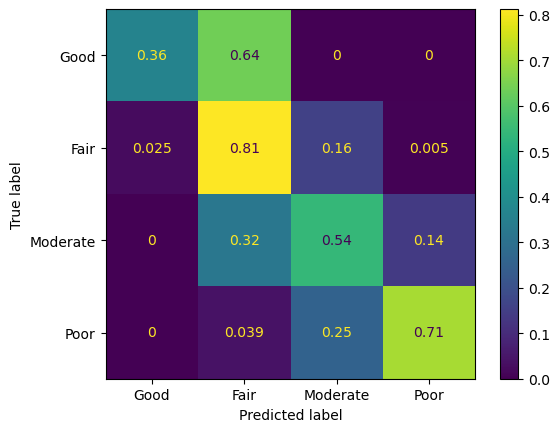

In [68]:
y_predict=model.predict(X_test).argmax(axis=1)
y_predict_cat=pd.Series(y_predict).map(aqi_labels)
y_test_cat=pd.Series(y_test).map(aqi_labels)

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=metrics.confusion_matrix(y_true=y_test_cat,y_pred=y_predict_cat,labels=list(aqi_labels.values()),normalize="true")
disp = metrics.ConfusionMatrixDisplay(cm,display_labels=list(aqi_labels.values()))
disp.plot()

Text(0.5, 0, 'Epoch')

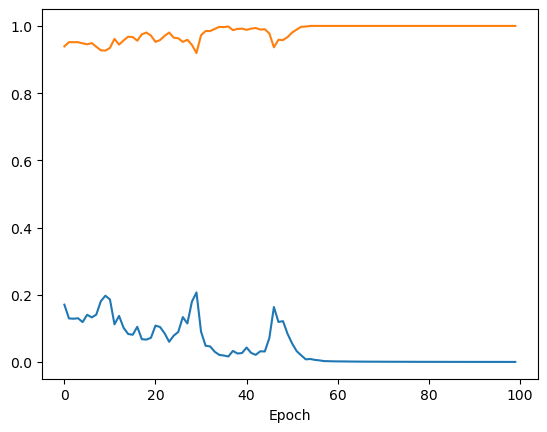

In [69]:
plt.plot(hist.history["sparse_categorical_crossentropy"],label="crossentropy")
plt.plot(hist.history["accuracy"],label="accuracy")
plt.xlabel("Epoch")

In [77]:
#create a simple neural Network
initializer = tf.keras.initializers.HeNormal(seed=3)
model_complex = keras.Sequential()
model_complex.add(keras.Input(shape=(55,)))
for i in range(10):
    model_complex.add(layers.Dense(70,activation="relu",name=f"hidden_layer_{i}",kernel_initializer=initializer))
model_complex.add(layers.Dropout(0.2))
model_complex.add(layers.Dense(60,activation="relu",name=f"hidden_layer_-3",kernel_initializer=initializer))
model_complex.add(layers.Dense(60,activation="relu",name=f"hidden_layer_-2",kernel_initializer=initializer))

model_complex.add(layers.Dense(4,activation="softmax",name="output_layer"))

model_complex.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_0 (Dense)      (None, 70)                3920      
                                                                 
 hidden_layer_1 (Dense)      (None, 70)                4970      
                                                                 
 hidden_layer_2 (Dense)      (None, 70)                4970      
                                                                 
 hidden_layer_3 (Dense)      (None, 70)                4970      
                                                                 
 hidden_layer_4 (Dense)      (None, 70)                4970      
                                                                 
 hidden_layer_5 (Dense)      (None, 70)                4970      
                                                                 
 hidden_layer_6 (Dense)      (None, 70)               

In [78]:
model_complex.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # this loss function fits for 2 or more categorial labels, 
              metrics=['accuracy',"sparse_categorical_crossentropy","mean_squared_error"])
hist=model_complex.fit(X_train, y_train, epochs=250,use_multiprocessing=True,batch_size=32)

Epoch 1/250
35/35 [==============================] - 6s 71ms/step - loss: 1.0281 - accuracy: 0.5690 - sparse_categorical_crossentropy: 1.0281 - mean_squared_error: 2.0823
Epoch 2/250
35/35 [==============================] - 2s 70ms/step - loss: 0.8209 - accuracy: 0.6443 - sparse_categorical_crossentropy: 0.8209 - mean_squared_error: 2.1091
Epoch 3/250
35/35 [==============================] - 2s 54ms/step - loss: 0.7377 - accuracy: 0.6685 - sparse_categorical_crossentropy: 0.7377 - mean_squared_error: 2.1219
Epoch 4/250
35/35 [==============================] - 2s 47ms/step - loss: 0.6456 - accuracy: 0.6971 - sparse_categorical_crossentropy: 0.6456 - mean_squared_error: 2.1265
Epoch 5/250
35/35 [==============================] - 2s 67ms/step - loss: 0.6740 - accuracy: 0.7061 - sparse_categorical_crossentropy: 0.6740 - mean_squared_error: 2.1278
Epoch 6/250
35/35 [==============================] - 2s 62ms/step - loss: 0.6136 - accuracy: 0.7115 - sparse_categorical_crossentropy: 0.6136 - m

12/12 [==============================] - 1s 27ms/step
Test Score of the Models
score of the model: 0.71314
balanced score of the model: 0.60156
f1 score of the model: 0.71105


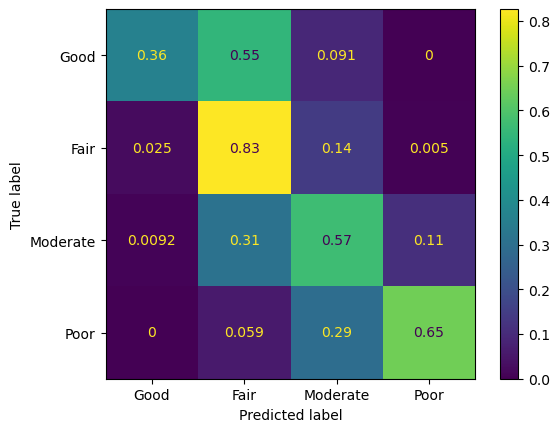

In [79]:
y_predict=model_complex.predict(X_test).argmax(axis=1)
y_predict_cat=pd.Series(y_predict).map(aqi_labels)
y_test_cat=pd.Series(y_test).map(aqi_labels)

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=metrics.confusion_matrix(y_true=y_test_cat,y_pred=y_predict_cat,labels=list(aqi_labels.values()),normalize="true")
disp = metrics.ConfusionMatrixDisplay(cm,display_labels=list(aqi_labels.values()))
disp.plot()

Text(0.5, 0, 'Epoch')

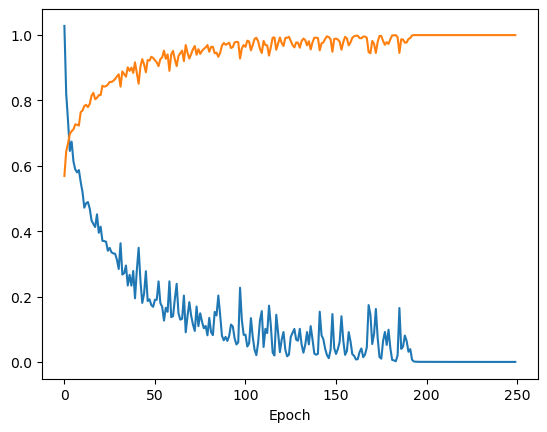

In [80]:
plt.plot(hist.history["sparse_categorical_crossentropy"],label="crossentropy")
plt.plot(hist.history["accuracy"],label="accuracy")
plt.xlabel("Epoch")

In [81]:
name="model_O3_250_epochs_12layer"
model.save(f"keras_models/{name}")

INFO:tensorflow:Assets written to: keras_models/model_O3_250_epochs_12layer/assets
